In [151]:
# install packages
import sys

# !{sys.executable} -m pip install matplotlib


In [152]:

import pandas as pd

# read in datasets
trainData = pd.read_csv("./Dataset/mnist_train.csv", header=None)
testData = pd.read_csv("./Dataset/mnist_test.csv", header=None)

In [153]:
# Get X and Y data
yTrain = {'Y': trainData[0]}
yTrain = pd.DataFrame(yTrain)
del trainData[0]

yTest = {'Y': testData[0]}
yTest = pd.DataFrame(yTest)
del testData[0]



In [154]:
# training digit count
display(yTrain.value_counts())

Y
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64

In [155]:
# Create Test and Train Dataloader
from torch.utils.data import DataLoader
import torch
import numpy as np
from PIL import Image

# create custom dataset
class createDataset():
    def __init__(self, images, numbers, transform=None):
        self.images = images
        self.numbers = numbers
        # Store the transform to apply to the data
        self.transform = transform

    def __len__(self):
        return len(self.numbers)

    def __getitem__(self, idx):
        image = self.images.iloc[idx].values
        number =self.numbers.iloc[idx].values

        # nromalize image
        image = image/ 255
        # reshape image for transformation
        image = np.reshape(image,[1,28,28])
        # image = np.pad(image,pad_width=2)

        # Apply the transform to the image, if specified
        if self.transform:
            # convert numpy array to PIL image
            image = Image.fromarray((image).astype(np.uint8))

            # perform transformation on the image
            image = self.transform(image)

        return image, number

trainDataset = createDataset(trainData,yTrain)
testDataset = createDataset(testData,yTest)



In [156]:
# Augment the dataset (adds robustness and increases training data)
import torch
from torchvision import transforms

# function to add guassain noise to the images
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        print(tensor)
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


# Create the transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    AddGaussianNoise(0.,1.)
])

# Apply the transformations to the dataset
# trainaugmented = createDataset(trainData,yTrain, transform = train_transform)
trainaugmented = createDataset(trainData,yTrain)



In [157]:

# Create DataLoader for train, validation and testing
batchSize = 32
trainloader = DataLoader(trainaugmented,batch_size=100,shuffle=True)
testloader = DataLoader(testDataset, batch_size=8)

# size of neural network input
inputSize = len(trainData.sample().values[0])

# num of classes
numClasses =  len(yTrain['Y'].unique())

# shape of the input image
print(next(iter(trainloader))[0].shape)


torch.Size([100, 1, 28, 28])


In [158]:
# Build Network
import torch.nn as nn
import torch

class numberPrediction(nn.Module):
    def __init__(self):
        super(numberPrediction, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)

   
        return
        
    def forward(self, x):
        x = x.to(torch.float32)
        x = self.conv1(x)
        x = self.conv2(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)   


        output = self.out(x)
        return output, x    # return x for visualization

# create and print model
predictionModel = numberPrediction()
print(predictionModel.parameters)


# Declaring Criterion and Optimizer
criterion = nn.CrossEntropyLoss()   
criterion

from torch import optim
optimizer = optim.Adam(predictionModel.parameters(), lr = 0.01)   
optimizer

<bound method Module.parameters of numberPrediction(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)>


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [159]:
# Training Model
import time
import numpy as np
from torch.autograd import Variable

class trainModel():
    def __init__(self):
        self.train_loss = 0.0
        self.total = 0
        self.correct = 0
        self.start_time = 0
        self.trainLossArray = []
        self.TrainAccuracyArray = []
        self.epochArray = []

    def updateModel(self, data):
        # deconstructing input
        inputs = data[0]
        labels = data[1]

        # inputs = inputs.squeeze(1)
        # print(inputs.size())
        # Forward Pass
        output = predictionModel(Variable(inputs))
        # print(labels)
        labels = labels.squeeze(1)
        # print(labels)

        # print(len(output))
        # Find the Loss
        loss = criterion(output[0],labels)

        # Clear the gradients
        optimizer.zero_grad()

        # Calculate gradients
        loss.backward()

        # Update Weights
        optimizer.step()

        # Calculate Loss
        self.train_loss +=loss.item() * labels.size(0)

        _, predicted = torch.max(output[0], 1)
        self.total += labels.size(0)
        self.correct += (predicted == labels).sum().item()
        accuracy = 100 * self.correct / self.total
        return accuracy, predicted

    def training(self, epochs):
        for epoch in range(epochs):
            self.train_loss = 0.0
            self.total = 0
            self.correct = 0
            self.start_time = time.time()
            for i, data in enumerate(trainloader):
                # train and update model
                accuracy, predicted = self.updateModel(data)

                # print every 10 batches
                if i % 10 == 0:    
                    batch_time = time.time()
                    speed = (i+1)/(batch_time-self.start_time)
                    print('[%d, %5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' % (epoch + 1, i, self.train_loss, speed, accuracy))

            predictionModel.eval()    
            self.TrainAccuracyArray.append(accuracy)
            self.trainLossArray.append(self.train_loss)
            self.epochArray.append(epoch)
        return

    def graphs(self):
        import matplotlib.pyplot as plt
        # plot the training graphs
        figure, axis = plt.subplots(2, 2)
        axis[0,0].plot(self.epochArray,self.trainLossArray)
        axis[0,0].set_title("Training Loss")


        axis[1,0].plot(self.epochArray,self.TrainAccuracyArray)
        axis[1,0].set_title("Training Accuracy")

        plt.show()
        return

# Training parameters
epochs = 20
model = trainModel()
model.training(epochs)

[1,     0] loss: 230.299, speed: 32.26, accuracy: 8.00 %
[1,    10] loss: 2177.823, speed: 34.16, accuracy: 39.55 %
[1,    20] loss: 2913.959, speed: 34.71, accuracy: 57.14 %
[1,    30] loss: 3308.859, speed: 34.68, accuracy: 66.87 %
[1,    40] loss: 3515.471, speed: 34.95, accuracy: 73.39 %
[1,    50] loss: 3782.817, speed: 34.86, accuracy: 77.18 %
[1,    60] loss: 3969.740, speed: 34.96, accuracy: 80.00 %
[1,    70] loss: 4153.863, speed: 35.01, accuracy: 81.99 %
[1,    80] loss: 4279.073, speed: 34.99, accuracy: 83.72 %
[1,    90] loss: 4432.793, speed: 35.05, accuracy: 85.00 %
[1,   100] loss: 4531.792, speed: 35.13, accuracy: 86.16 %
[1,   110] loss: 4685.018, speed: 35.09, accuracy: 87.07 %
[1,   120] loss: 4782.672, speed: 35.11, accuracy: 87.93 %
[1,   130] loss: 4879.291, speed: 35.17, accuracy: 88.59 %
[1,   140] loss: 4992.591, speed: 35.25, accuracy: 89.11 %
[1,   150] loss: 5083.356, speed: 35.23, accuracy: 89.63 %
[1,   160] loss: 5174.708, speed: 35.26, accuracy: 90.09 %

In [139]:
from torch.autograd import Variable
import math

loaders = {
    'train' : trainloader,
    
    'test'  : testloader,
}

num_epochs = 10

def getaccuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        total, correct = 0,0
  
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels.squeeze(1))   # batch y
            # print(b_x)
            output = cnn(b_x)[0]  
            # print(output.shape) 
            # print(b_y.shape)            
            loss = criterion(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()            

            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += math.floor(labels.size(0) * torch.mean(torch.eq(predicted,labels).float()))
            # accuracy = torch.mean(torch.eq(predicted,labels).float())
            accuracy = getaccuracy(output,labels)
 
            if (i+1) % 100 == 0:
                # accuracy = 100 *correct / total
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),accuracy))
                print(predicted)
                pass
        pass
    
    
    pass
# train(num_epochs, predictionModel, loaders)

Epoch [1/10], Step [100/600], Loss: 0.0631, Accuracy: 10.5200
tensor([6, 5, 4, 9, 9, 9, 1, 6, 6, 4, 5, 7, 3, 2, 5, 2, 1, 4, 3, 7, 2, 2, 4, 6,
        1, 9, 8, 3, 6, 2, 4, 7, 3, 4, 4, 3, 9, 9, 8, 5, 3, 7, 9, 2, 1, 6, 8, 5,
        0, 0, 8, 4, 5, 7, 0, 4, 9, 6, 4, 8, 8, 6, 7, 0, 9, 1, 6, 8, 7, 5, 0, 3,
        9, 1, 9, 2, 1, 9, 8, 1, 5, 3, 9, 7, 4, 8, 7, 9, 0, 1, 9, 5, 7, 8, 0, 6,
        1, 0, 5, 9])
Epoch [1/10], Step [200/600], Loss: 0.0168, Accuracy: 11.6600
tensor([6, 8, 5, 6, 5, 6, 8, 9, 6, 6, 7, 1, 3, 8, 4, 4, 9, 5, 2, 6, 0, 6, 1, 3,
        6, 1, 3, 4, 9, 3, 8, 7, 7, 3, 6, 8, 5, 8, 1, 3, 9, 8, 7, 6, 0, 2, 2, 1,
        1, 5, 7, 0, 2, 2, 3, 3, 7, 3, 9, 8, 7, 4, 0, 3, 2, 7, 2, 8, 1, 2, 2, 2,
        4, 3, 3, 8, 2, 7, 6, 7, 2, 9, 2, 6, 6, 6, 8, 3, 1, 3, 1, 2, 6, 7, 7, 6,
        1, 2, 9, 0])
Epoch [1/10], Step [300/600], Loss: 0.0233, Accuracy: 10.5800
tensor([3, 1, 3, 5, 5, 7, 5, 4, 5, 0, 5, 0, 0, 3, 0, 8, 7, 2, 2, 0, 8, 6, 8, 2,
        2, 7, 3, 1, 3, 0, 1, 3, 1, 9, 3, 3, 8, 3, 5,

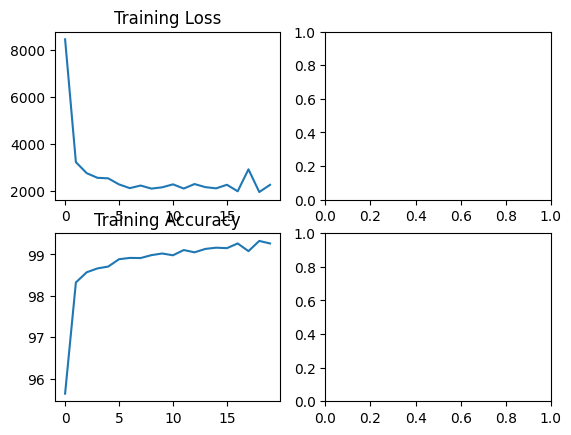

In [160]:

# generate graphs
model.graphs()

In [161]:

# test the model
total = 0.0
correct = 0.0

for data in testloader:
    # get the data
    inputs = data[0]
    labels = data[1]

    # make predictions
    output = predictionModel(inputs)[0]

 

    # accuracy =getaccuracy(output,labels)
    _, predicted = torch.max(output, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy = 100 *correct /total
    print ('Accuracy: {:.4f}'.format(accuracy))

print(len(labels), len(predicted))
print(correct, total)
print(accuracy)
print(predicted)
print(labels)

Accuracy: 150.0000
Accuracy: 162.5000
Accuracy: 154.1667
Accuracy: 159.3750
Accuracy: 162.5000
Accuracy: 160.4167
Accuracy: 162.5000
Accuracy: 157.8125
Accuracy: 159.7222
Accuracy: 161.2500
Accuracy: 162.5000
Accuracy: 162.5000
Accuracy: 159.6154
Accuracy: 159.8214
Accuracy: 162.5000
Accuracy: 161.7188
Accuracy: 162.5000
Accuracy: 161.8056
Accuracy: 160.5263
Accuracy: 161.2500
Accuracy: 166.6667
Accuracy: 165.9091
Accuracy: 169.5652
Accuracy: 169.7917
Accuracy: 168.0000
Accuracy: 169.2308
Accuracy: 169.4444
Accuracy: 169.6429
Accuracy: 168.9655
Accuracy: 168.3333
Accuracy: 166.1290
Accuracy: 165.6250
Accuracy: 165.5303
Accuracy: 165.8088
Accuracy: 166.7857
Accuracy: 165.9722
Accuracy: 164.8649
Accuracy: 164.4737
Accuracy: 164.7436
Accuracy: 163.7500
Accuracy: 164.0244
Accuracy: 164.8810
Accuracy: 163.9535
Accuracy: 164.7727
Accuracy: 164.4444
Accuracy: 164.6739
Accuracy: 163.8298
Accuracy: 164.0625
Accuracy: 164.2857
Accuracy: 164.0000
Accuracy: 163.7255
Accuracy: 165.3846
Accuracy: 16

In [3]:
import cv2
import os
from PIL import Image

# read list of test images
folder = './images/'
img_list =  os.listdir(folder)

# predict for each file
for image in img_list:
    file_path = folder + image

    test_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    # format Image
    img_resized = cv2.resize(test_image, (28, 28), interpolation=cv2.INTER_LINEAR)

    # convert test image to tensor for prediction
    tensor_img = torch.from_numpy(~img_resized)
    reshaped_img = np.reshape(tensor_img, [1,1,28,28])
 
    # make predictions
    output = predictionModel(reshaped_img)[0]
    _, predicted = torch.max(output, 1)
    print(f"\nImage: {file_path} \nPrediction: {predicted}")

    # squeeze 1 dimension
    reshaped_img = reshaped_img.squeeze()
    numImage = Image.fromarray((reshaped_img.numpy()))

    display(numImage)

# Note the testing did not work on images that were not inverted


NameError: name 'torch' is not defined